<a href="https://colab.research.google.com/github/at19990/sports_analytics/blob/master/p04-xgb_glm_gam-basketball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# バスケットボールの勝率予測

NBAのチームスタッツを取得し、各指標の勝率への寄与を分析し、指標から勝率を予測するモデルを作成する

In [0]:
# 必要なパッケージのインストール
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install pandas==0.23.4  # バージョンを下げないとread_htmlのオプションがうまく動かない
!pip install pygam

In [0]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import scipy.stats as sp
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

## データの取得・整形

ESPN ([https://www.espn.com/nba](https://www.espn.com/nba)) から2010-2019シーズンのNBAのチームスタッツを取得し、整形する

In [0]:
# 配列を用意
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
html = ['', '', '', '', '', '', '', '', '', '']
html_2 = ['', '', '', '', '', '', '', '', '', '']
df = [[], [], [], [], [], [], [], [], [], []]
df_2 = [[], [], [], [], [], [], [], [], [], []]

In [0]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

In [0]:
# seleniumを用いてスクリプト適用後のページソースを取得
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)
driver.implicitly_wait(5)
for year in years:
  driver.get("https://www.espn.com/nba/stats/team/_/season/{0}/seasontype/2".format(year))
  html[year-2010] = driver.page_source.encode('utf-8')
  driver.get("https://www.espn.com/nba/standings/_/season/{0}/group/league".format(year))
  html_2[year-2010] = driver.page_source.encode('utf-8')

In [0]:
# チームスタッツを取得
for i in range(10):
  df[i] = pd.io.html.read_html(html[i])[0]
  df[i] = df[i].join(pd.io.html.read_html(html[i])[1])
  df[i].Team = df[i].Team.str.lower()
  df[i] = df[i].iloc[:,[1, 6, 9, 12, 13, 14, 16, 17, 18, 19, 20]]
  df[i].Team = df[i].Team + '{0}'.format(i + 2010)
df_stats = pd.concat([df[0], df[1], df[2], df[3], df[4], df[5], df[6], df[7], df[8], df[9]])
df_stats = df_stats.reset_index(drop=True)

In [0]:
# チーム勝率を取得
for i in range(10):
  df_2[i] = pd.io.html.read_html(html_2[i], header=None)[0]
  df_2[i] = df_2[i].rename(columns={0:'Team'})
  # df_2[i].Team = df_2[i].Team.str[3:]
  df_2[i].Team = df_2[i].Team.str.replace('.\s--', '')
  pattern = 'SAC|MIL|TOR|GS|DEN|HOU|POR|PHI|UTAH|BOS|OKC|IND|SA|LAC|ORL|BKN|DET|CHA|MIA|LAL|MIN|MEM|NO|DAL|WSH|ATL|CHI|CLE|PHX|NY|NJ'
  df_2[i].Team = df_2[i].Team.str.replace(pattern, '')
  df_2[i].Team = df_2[i].Team.str.lower()
  df_2[i] = df_2[i].join(pd.io.html.read_html(html_2[i], header=None)[1].iloc[:,[2]])
  df_2[i].Team = df_2[i].Team + '{0}'.format(i + 2010)
df_pct = pd.concat([df_2[0], df_2[1], df_2[2], df_2[3], df_2[4], df_2[5], df_2[6], df_2[7], df_2[8], df_2[9]])
df_pct = df_pct.reset_index(drop=True)

In [8]:
# スタッツと勝率を結合
df_3 = pd.merge(df_pct, df_stats, on='Team', how='left')
df_3 = df_3.dropna().reset_index(drop=True)
df_3

,Team,PCT,FG%,3P%,FT%,OR,DR,AST,STL,BLK,TO,PF
0,cleveland cavaliers2010,0.744,48.5,38.1,72.0,9.6,32.8,22.4,6.9,5.2,13.9,19.4
1,orlando magic2010,0.720,47.0,37.5,72.4,9.9,33.4,19.7,6.2,5.6,14.1,19.9
2,los angeles lakers2010,0.695,45.7,34.1,76.5,11.9,32.5,21.1,7.5,4.9,13.4,19.4
3,dallas mavericks2010,0.671,46.5,37.3,81.6,10.2,31.5,23.4,7.6,5.5,12.9,19.1
4,phoenix suns2010,0.659,49.2,41.2,77.0,11.1,31.9,23.3,5.8,5.1,14.8,20.9
5,denver nuggets2010,0.646,46.8,35.9,77.2,10.8,30.5,21.0,8.3,5.1,13.9,22.5
6,atlanta hawks2010,0.646,46.8,36.0,75.9,11.8,29.9,21.8,7.2,5.0,12.0,19.9
7,utah jazz2010,0.646,49.1,36.4,74.1,10.6,31.6,26.7,8.2,4.9,15.2,22.7
8,boston celtics2010,0.610,48.3,34.8,74.6,8.7,29.9,23.5,8.5,4.9,14.9,22.1
9,portland trail blazers2010,0.610,46.1,35.4,79.0,11.1,29.1,20.4,6.4,4.3,12.3,20.9


### 指標一覧

- __PCT__ : 勝率

- __FG%__ : フィールドゴール成功率

- __3P%__ : スリーポイント成功率

- __OR__ : オフェンスリバウンド数 (1試合平均)

- __DR__ : ディフェンスリバウンド数 (1試合平均)

- __AST__ : アシスト数 (1試合平均)

- __STL__ : スティール数 (1試合平均)

- __BLK__ : ブロック数 (1試合平均)

- __TO__ : ターンオーバー数 (1試合平均)

- __PF__ : ファール数 (1試合平均)

## ヒートマップの作成

各変数の相関を可視化するため、ヒートマップを作成する

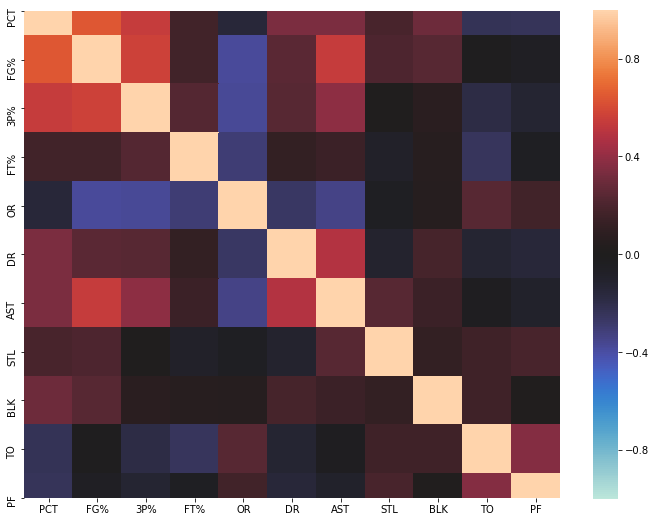

In [9]:
# ヒートマップの出力
fig, ax = plt.subplots(figsize=(12, 9)) 
df_corr = df_3.corr()
sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)
fig.show()

In [10]:
# 勝率との他のパラメーターの相関のみを出力
df_corr.iloc[1:, 0]

FG%    0.644484
3P%    0.540351
FT%    0.167117
OR    -0.147903
DR     0.343581
AST    0.343340
STL    0.194480
BLK    0.302032
TO    -0.230838
PF    -0.235059
Name: PCT, dtype: float64

In [0]:
# トレインデータとテストデータ / 目的変数と説明変数 を分割 
y = df_3.iloc[:, 1]
X = df_3.iloc[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## XGBoost

GDBT (勾配ブースティング木) の一種

使いやすさと精度の高さから分析コンペでよく用いられる

複数の弱学習器 (決定木) を次々に作り、それらの予測結果を統合して予測する

決定木の分岐は勾配 (対象とする点での関数の傾き) や二階微分の値によって定められる

In [0]:
import xgboost as xgb

# 学習データからXGBoost用のデータを生成
dm_train = xgb.DMatrix(X_train, label=y_train)

param = {
    'objective': 'reg:logistic'  # 目的変数をロジスティック回帰で推定
}

# モデル作成
model = xgb.train(param, dm_train)

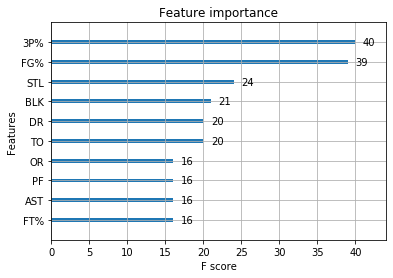

In [13]:
# 各変数の重要度を出力
xgb.plot_importance(model)

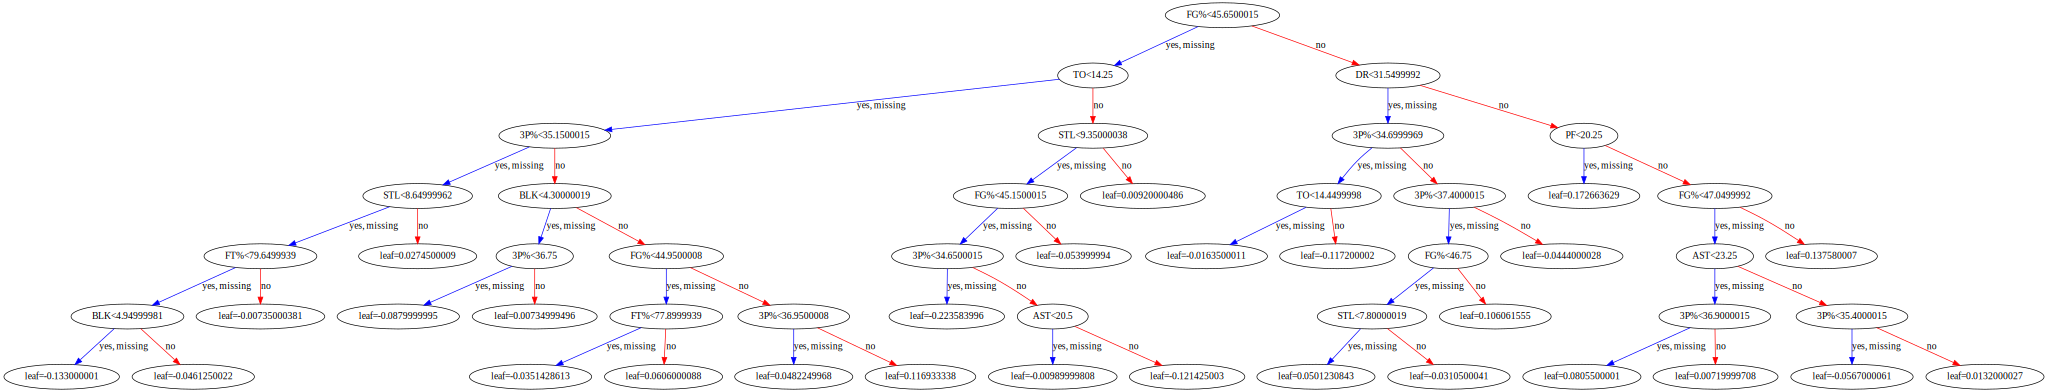

In [14]:
# 決定木の可視化
xgb.to_graphviz(model)

In [0]:
# テストデータの予測
dm_test = xgb.DMatrix(X_test)
y_pred = model.predict(dm_test)

In [16]:
# 正解と予測値を並べて出力
df_result = pd.DataFrame({'actual':y_test.values.astype(np.float), 'predict':y_pred})
df_result

,actual,predict
0,0.585,0.518227
1,0.683,0.525868
2,0.646,0.627905
3,0.646,0.442352
4,0.500,0.551316
5,0.622,0.554690
6,0.256,0.380198
7,0.545,0.486771
8,0.646,0.553637
9,0.707,0.720639


In [17]:
# 誤差を出力
print('(XGBoostのRMSE) = {0}'.format(np.sqrt(mean_squared_error(y_test.values.astype(np.float), y_pred))))

(XGBoostのRMSE) = 0.11171723926321749


## GLM (一般化線形モデル)

目的変数が正規分布に従わない場合にも適用可能なモデル

目的変数の値をある関数 $g$ で変換することで、$x_1, x_2, \dots, x_n$ に重みづけした形 (一般線形モデルと同様に) でモデルを作成できる

$$g (y) = \alpha + \sum_{n=1}^n \beta_i x_i + \varepsilon$$

In [0]:
from pygam import l, LinearGAM

# GLMのモデル作成
glm = LinearGAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7) + l(8) + l(9))
glm = glm.fit(X_train, y_train)

In [0]:
# スプライン関数のプロット用
def plot_splines(glm):
    fig, axes = plt.subplots(2, 5, figsize=(18, 12))
    axes = np.array(axes).flatten()
    for i, (ax, title, p_value) in enumerate(zip(axes, X_train.columns, glm.statistics_['p_values'])):
        XX = glm.generate_X_grid(term=i)
        ax.plot(XX[:, i], glm.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], glm.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.axhline(0, c='#cccccc')
        ax.set_title("{0:} (p={1:.2})".format(title, p_value))
        ax.set_yticks([])

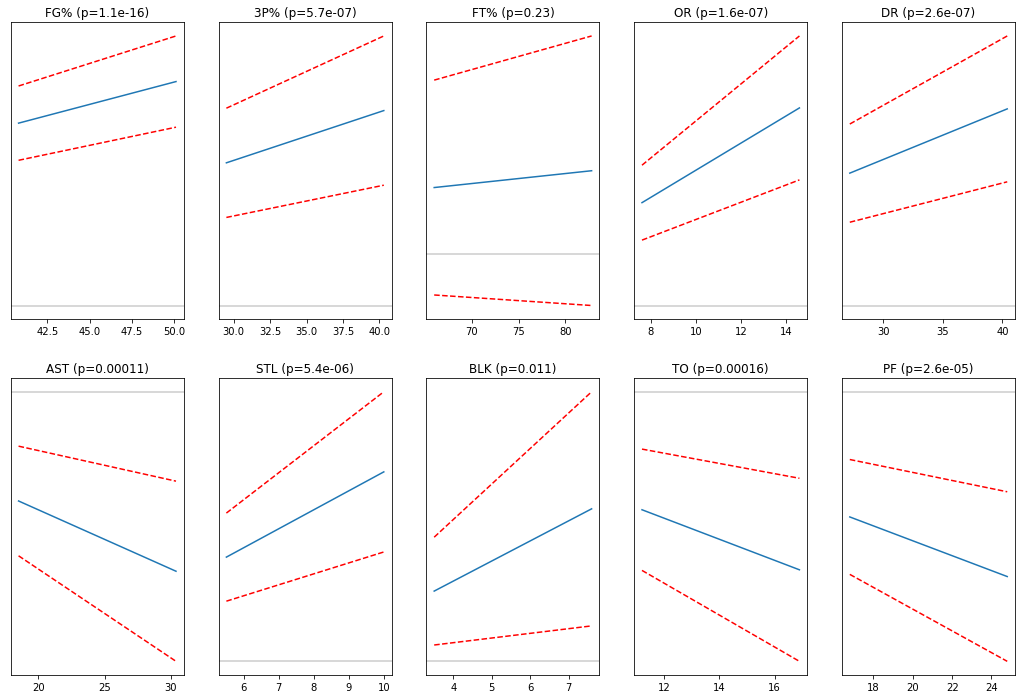

In [20]:
# グラフ出力
plot_splines(glm)

In [0]:
# テストデータの予測
y_pred_2 = glm.predict(X_test)

In [22]:
# 正解と予測値を並べて出力
df_result_2 = pd.DataFrame({'actual':y_test.values.astype(np.float), 'predict':y_pred_2})
df_result_2

,actual,predict
0,0.585,0.534151
1,0.683,0.498904
2,0.646,0.573138
3,0.646,0.433019
4,0.500,0.558636
5,0.622,0.573566
6,0.256,0.395376
7,0.545,0.484670
8,0.646,0.666389
9,0.707,0.779052


In [23]:
# 誤差の出力
print('(GLMのRMSE) = {0}'.format(np.sqrt(mean_squared_error(y_test.values.astype(np.float), y_pred_2))))

(GLMのRMSE) = 0.09206827025656321


## GAM (一般化加法モデル)

一般化加法モデルの特徴量 $x_1, x_2, \dots, x_n$ に重みづけするだけでなく、複雑な形をもった関数とすることでより複雑で非線形な現象・関係を表現できる

各関数は平滑化スプラインによって曲線近似をおこなって定める

$$g (y) = \alpha + \sum_{n=1}^n f_i (x_i) + \varepsilon$$

In [0]:
from pygam import s, LinearGAM

# GAMのモデル作成
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))
gam = gam.fit(X_train, y_train)

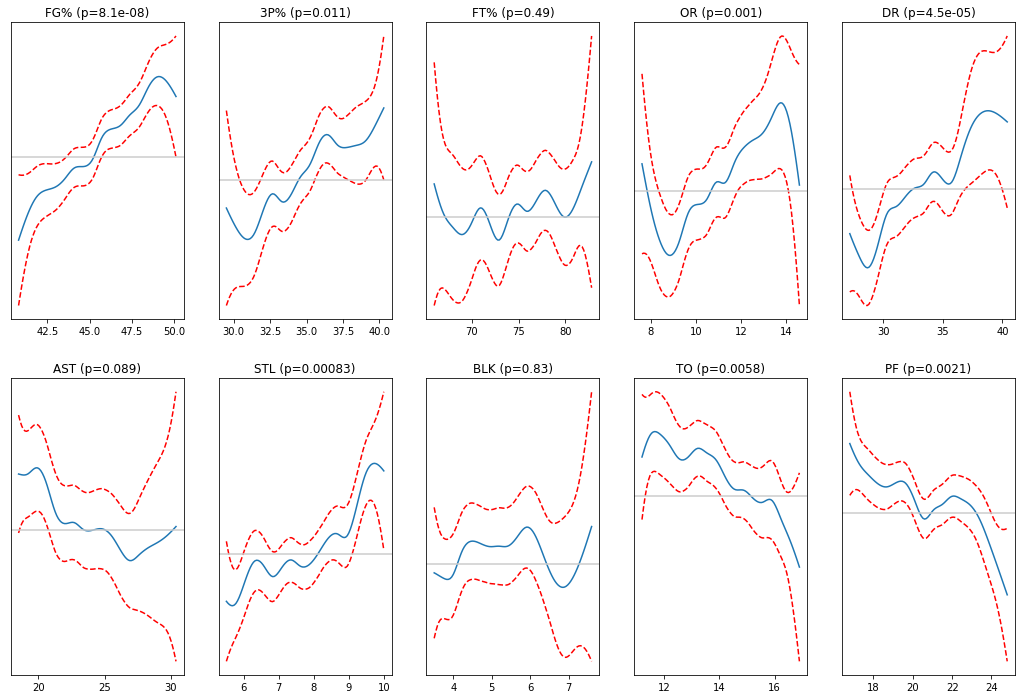

In [25]:
# グラフ出力
plot_splines(gam)

In [0]:
# テストデータの予測
y_pred_3 = gam.predict(X_test)

In [27]:
# 正解と予測値を並べて出力
df_result_3 = pd.DataFrame({'actual':y_test.values.astype(np.float), 'predict':y_pred_3})
df_result_3

,actual,predict
0,0.585,0.499004
1,0.683,0.489262
2,0.646,0.552219
3,0.646,0.359460
4,0.500,0.489148
5,0.622,0.565758
6,0.256,0.404677
7,0.545,0.496457
8,0.646,0.654207
9,0.707,0.616361


In [28]:
# 誤差の出力
print('(GAMのRMSE) = {0}'.format(np.sqrt(mean_squared_error(y_test.values.astype(np.float), y_pred_3))))

(GAMのRMSE) = 0.10594301990384208


## 参考

- 『Kaggleで勝つデータ分析の技術』 (2019, 門脇大輔 et al., 技術評論社)


- 『データ解析のための統計モデリング入門』 (2012, 久保拓弥, 岩波書店)

- [PythonでXGBoostを使う](https://ohke.hateblo.jp/entry/2019/02/16/230000)

- [xgboostのパラメータ](http://puyokw.hatenablog.com/entry/2015/04/11/040941)

- [一般化加法モデル（GAM）について考える](https://rmizutaa.hatenablog.com/entry/2019/03/23/201720)

- [Sports Analyst Meetup #5 LT - 目指せPGAツアー賞金王](https://speakerdeck.com/openjny/sports-analyst-meetup-number-5-lt-mu-zhi-sepgatuashang-jin-wang?slide=17)